In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn

seaborn.set()
seaborn.set_style("ticks")
seaborn.set_context("poster")
from matplotlib import pyplot

In [126]:
def print_auc(title, data, marker_styles, curve_colors, curve_styles, 
              curve_labels, yticks, leg_title, rand_base, leg_loc, leg_flag, name):
    fig, ax = plt.subplots(figsize=(4, 3))
    plt.title(title , fontsize=25)
    plt.xlabel(r'Model Size Factor', fontsize=25)
    plt.ylabel('AUC Random Ablation', fontsize=25)
    plt.xlim((0.245, 4.07))
    plt.ylim((-0.01, np.max(yticks)))
    plt.grid(True, which='both')
    plt.xscale('log')
    plt.xticks(size_factors, size_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:,0] != 0)
        plt.errorbar(size_factors[non_0_idx], data[curve_idx,non_0_idx,0], yerr=data[curve_idx,non_0_idx,1].T,
                 marker=marker_styles[curve_idx], markersize=7, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=3)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
    if leg_flag:
        leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
        leg.get_title().set_fontsize('12')
    plt.rc('xtick',labelsize=8)

    plt.show()
    fig.savefig(name+".pdf",format='pdf', bbox_inches='tight',dpi=1000)

In [127]:
sys.path.append('../')
import experiments

range_len = 7
curves = 4
curve_labels = ['AlexNet', 'AlexNet-Random', 'ResNet56', 'ResNet56-Random']
curve_colors = ['darkblue', 'darkblue', 'indianred', 'indianred']
curve_styles = ['-', '--', '-', '--']
marker_styles = ['o', 'v', 'o', 'v']

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 2
results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds, curves, sizes, 3))
results_targeted = np.zeros((seeds, curves, sizes, 3))
results_targeted_test = np.zeros((seeds, curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

for seed in range(seeds):
    for ID in range(62, 92):
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 1  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 0  # all regularizers
        else:
            continue

        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed, curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

    for ID in range(217, 231):
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            curve_idx = 3  # random labels
        elif opt.hyper.lr_bs_factor == 1:
            curve_idx = 2  # all regularizers
        else:
            continue

        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

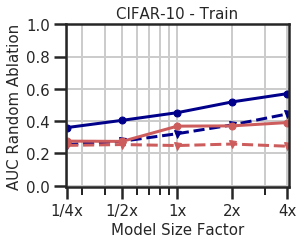

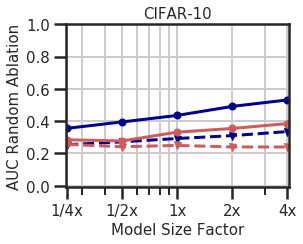

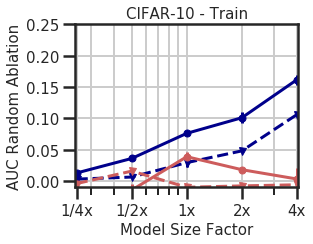

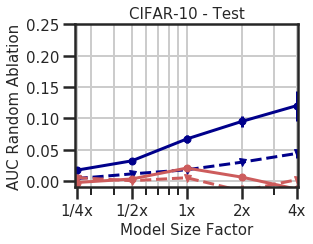

In [128]:
leg_loc = (0.0, 0.42)
  
print_auc(r'CIFAR-10 - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "auc_cifar_train")

        
print_auc(r'CIFAR-10', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "auc_cifar_test")

yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
print_auc(r'CIFAR-10 - Train', results-results_targeted, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "target_cifar_train")

print_auc(r'CIFAR-10 - Test', results_test-results_targeted_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "target_cifar_test")



In [129]:
sys.path.append('../')
import experiments

range_len = 7
curves = 5
curve_labels = ['None', 'All', 'Data Aug.', 'Dropout', 'W. Decay']
curve_colors = ['slateblue', 'darkblue', 'purple', 'violet', 'pink']
curve_styles = ['-', '-', '--', '--', '--']
marker_styles = ['o', 'o', 'v', 'v', 'v']

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 3
results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds,curves, sizes, 3))
results_targeted = np.zeros((seeds,curves, sizes, 3))
results_targeted_test = np.zeros((seeds,curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(62, 92):
        opt = experiments.opt[ID]

        curve_idx = 0  # unregularized
        if opt.dataset.random_labels:
            continue  # random labels
        elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
            curve_idx = 1  # all regularizers
        elif opt.hyper.augmentation:
            curve_idx = 2
        elif opt.hyper.drop_train < 1:
            curve_idx = 3
        elif opt.hyper.weight_decay:
            curve_idx = 4
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp       
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

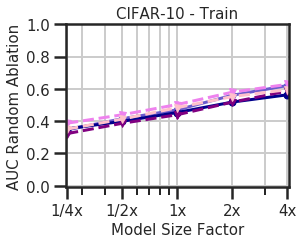

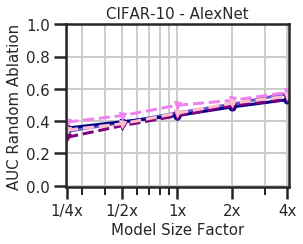

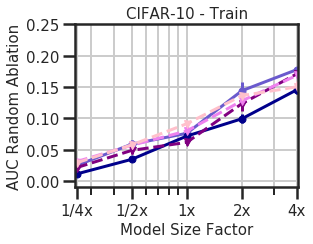

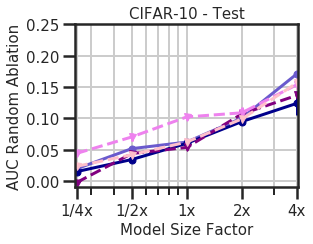

In [130]:
leg_loc = (0.0, 0.42)
  
print_auc(r'CIFAR-10 - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "auc_cifar_regularizers_train")

        
print_auc(r'CIFAR-10 - AlexNet', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "auc_cifar_regularizers_test")

yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
print_auc(r'CIFAR-10 - Train', results-results_targeted, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "target_cifar_regularizers_train")

print_auc(r'CIFAR-10 - Test', results_test-results_targeted_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 0.1,leg_loc, False,
                 "target_cifar_regularizers_test")



In [131]:
#Batch - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 6
curve_labels = ['AlexNet-k=1', 'AlexNet-k=0.25', 'AlexNet-k=4', 'ResNet-k=1', 'ResNet-k=0.25', 'ResNet-k=4']
curve_colors = ['slateblue', 'lightblue', 'lightblue', 'indianred', 'mistyrose', 'mistyrose']
curve_styles = ['-', '--', '--', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'o', 'v', 's']
lr_factor = [1, 0.25, 4]

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3

seeds = 2
results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds,curves, sizes, 3))
results_targeted = np.zeros((seeds,curves, sizes, 3))
results_targeted_test = np.zeros((seeds,curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in list(range(62, 92)) + list(range(157,217)) :

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        if not (opt.hyper.augmentation or opt.hyper.drop_train < 1 or opt.hyper.weight_decay):
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0]
        else:
            continue
            
        if ID == 166: #Not possible to calculate
            continue
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

        
    for ID in list(range(217,232)) + list(range(234,239)):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.random_labels:
            continue
        else:
            curve_idx = np.where(np.array(opt.hyper.lr_bs_factor) == lr_factor)[0][0] + 3
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

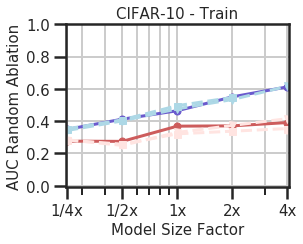

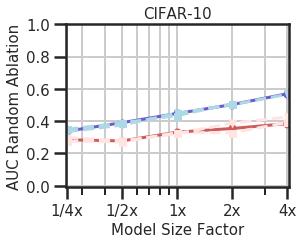

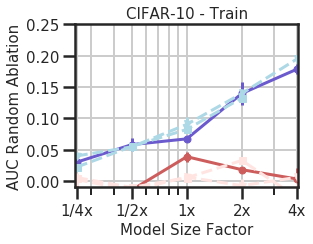

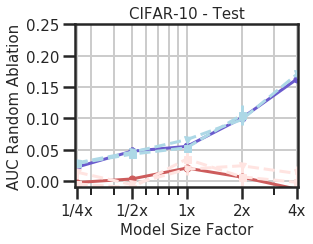

In [132]:
leg_loc = (0.0, 0.42)
  
print_auc(r'CIFAR-10 - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "auc_cifar_batch_train")

        
print_auc(r'CIFAR-10', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "auc_cifar_batch_test")

yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
print_auc(r'CIFAR-10 - Train', results-results_targeted, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "target_cifar_batch_train")

print_auc(r'CIFAR-10 - Test', results_test-results_targeted_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-k}$", 0.1,leg_loc, False,
                 "target_cifar_batch_test")



In [133]:
#Init - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 3
curve_labels = ['Glorot Norm', 'He Norm', 'Lecun Norm']
curve_colors = ['slateblue', 'skyblue', 'steelblue']
curve_styles = ['-',  '-',  '-']
marker_styles = ['o', 'o','o']

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 1

seeds = 2
results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds,curves, sizes, 3))
results_targeted = np.zeros((seeds,curves, sizes, 3))
results_targeted_test = np.zeros((seeds,curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [1, 3, 5]:
            continue
        
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

        
results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

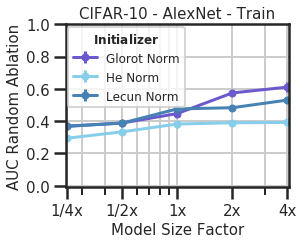

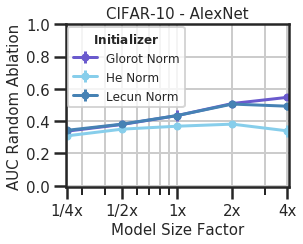

In [134]:
leg_loc = (0.01, 0.49)
  
print_auc(r'CIFAR-10 - AlexNet - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 0.1,leg_loc, True,
                 "auc_cifar_initializers_train")

        
print_auc(r'CIFAR-10 - AlexNet', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 0.1,leg_loc, True,
                 "auc_cifar_initializers_test")


In [135]:
#Init - CIFAR
sys.path.append('../')
import experiments

range_len = 7
curves = 3
curve_labels = ['Glorot Unif.', 'He Unif.', 'Lecun Unif.']
curve_colors = ['slateblue', 'skyblue',  'steelblue']
curve_styles = ['--', '--', '--']
marker_styles = ['v', 'v', 'v']

sizes = 5
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 1

seeds = 2
results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds,curves, sizes, 3))
results_targeted = np.zeros((seeds,curves, sizes, 3))
results_targeted_test = np.zeros((seeds,curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets


for seed in range(seeds):
    for ID in range(2,32):

        opt = experiments.opt[ID]

        curve_idx = opt.init_type // 2
        if opt.init_type in [0, 2, 4]:
            continue 
            
        size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

        csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed,curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

        
results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp 
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

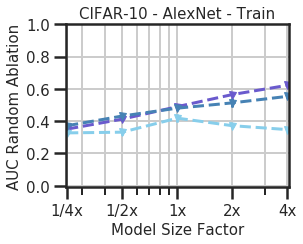

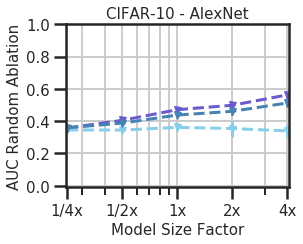

In [136]:
leg_loc = (0.01, 0.49)
  
print_auc(r'CIFAR-10 - AlexNet - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "auc_cifar_initializers2_train")

        
print_auc(r'CIFAR-10 - AlexNet', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Initializer}$", 0.1,leg_loc, False,
                 "auc_cifar_initializers2_test")


In [137]:
#MLPs

sys.path.append('../')
import experiments

range_len = 7
curves = 6
curve_labels = ['Unregularized', 'All Regularizers', 'Data Augment', 'Dropout', 'Weight Decay', 'Random Labels']
curve_colors = ['blue', 'green', 'darkviolet', 'maroon', 'orange', 'red']
curve_styles = ['-', '-', '--', '--', '--', '-']
sizes = 5
marker_styles = ['o', 'o', 'v', 'v', 'v', 'o']
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]


seeds = 3

results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds, curves, sizes, 3))
results_targeted = np.zeros((seeds, curves, sizes, 3))
results_targeted_test = np.zeros((seeds, curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for ID in range(243+25, 243+50):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        curve_idx = np.where(np.array(opt.hyper.learning_rate) == lr)[0][0]    
        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   

        csv_file =  experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=1", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        print(csv_file)

        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp


/om/user/xboix/share/robust/csvs/rand10000/ID268_MLP10K_seed=0_robustness.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

/om/user/xboix/share/robust/csvs/rand10000/ID269_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID270_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID271_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID272_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID273_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID274_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID275_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID276_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID277_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID278_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID279_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID280_MLP10K_seed=0_robustness.csv
/om/user/xboix/share/robust/csvs/rand10000/ID281_MLP10K_seed=0_r

In [138]:
#Base - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curves = 4
curve_labels = ['10 dim. - 1e-2', '10K dim. - 1e-2', '10 dim. - 1e4', '10K dim. - 1e4']
curve_colors = ['orange', 'purple', 'orange', 'purple']
curve_styles = ['-', '-', '--',  '--']
marker_styles = ['o', 'o', 'v',  'v']
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]


seeds = 1

results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds, curves, sizes, 3))
results_targeted = np.zeros((seeds, curves, sizes, 3))
results_targeted_test = np.zeros((seeds, curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for ID in range(243+0, 243+100):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 1
        else:
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 0

        if not opt.hyper.learning_rate == select_lr[curve_idx]:
            continue
            
        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   

        csv_file =  experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

        
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 3
        else:
            if opt.dnn.name == 'MLP1_linear':
                continue
            else:
                curve_idx = 2

        if not opt.hyper.init_factor == 1e5:
            continue
            
        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   

        csv_file =  experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

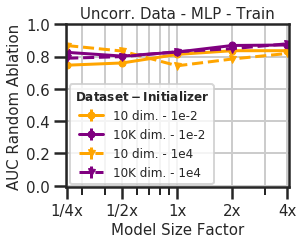

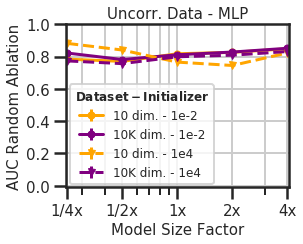

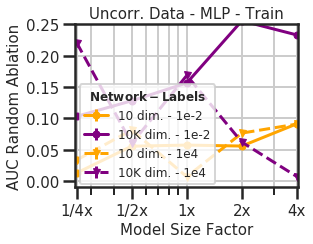

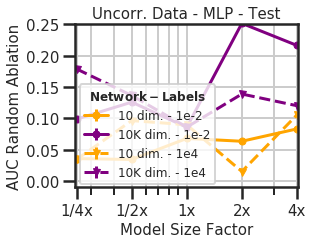

In [139]:
leg_loc = (0.02, 0.02)
  
print_auc(r'Uncorr. Data - MLP - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 0.1,leg_loc, True,
                 "auc_synthetic_train")

        
print_auc(r'Uncorr. Data - MLP', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Dataset-Initializer}$", 0.1,leg_loc, True,
                 "auc_synthetic_test")

yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
print_auc(r'Uncorr. Data - MLP - Train', results-results_targeted, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, True,
                 "target_synthetic_train")

print_auc(r'Uncorr. Data - MLP - Test', results_test-results_targeted_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, True,
                 "target_synthetic_test")

In [121]:
#Init - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("purple", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
curves = 5

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]


seeds = 1

results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds, curves, sizes, 3))
results_targeted = np.zeros((seeds, curves, sizes, 3))
results_targeted_test = np.zeros((seeds, curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10000":
            if opt.dnn.name == 'MLP1_linear':
                continue
        else:
            continue

        if not opt.hyper.init_factor in inits_fact:
            continue

        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   
        curve_idx = np.where(np.array(opt.hyper.init_factor) == (inits_fact))[0][0]  
        
        csv_file =  experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp
        

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

1
2
0
1
2
0
1
2
0
1
2
0
1
2
3
4
3
4
3
4
3
4
3
4


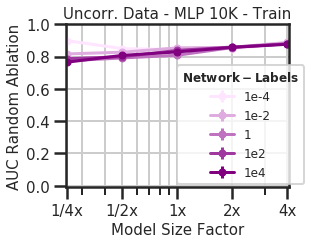

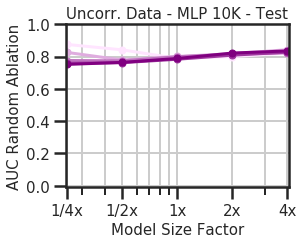

In [122]:
leg_loc = (0.50, 0.02)
  
print_auc(r'Uncorr. Data - MLP 10K - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, True,
                 "auc_synthetic_initializer_train")

        
print_auc(r'Uncorr. Data - MLP 10K - Test', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "auc_synthetic_initializer_test")


In [140]:
#Init - MLPs

sys.path.append('../')
import experiments

range_len = 7
sizes = 5
curve_labels = ['1e-4', '1e-2', '1', '1e2', '1e4']
cm = seaborn.light_palette("orange", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'o', 'o', 'o',  'o']
inits_fact = [1e-2, 1, 1e2, 1e4, 1e6]
curves = 5

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
knockout_range = np.linspace(0.0, 1.0, num=range_len)
crosses = 3
lr = [1, 1e-1, 1e-2, 1e-3, 1e-4]
factors = [1, 2, 4, 8, 16]
select_lr = [1e-1, 1e-2, 1e-3, 1e-3]


seeds = 1

results = np.zeros((seeds, curves, sizes, 3))
results_test = np.zeros((seeds, curves, sizes, 3))
results_targeted = np.zeros((seeds, curves, sizes, 3))
results_targeted_test = np.zeros((seeds, curves, sizes, 3))
# all are indexed [size_factor][nn_type][avg/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages within a net instead of between nets

# both are indexed [nn_type][size_factor]
for seed in range(seeds):
    for ID in range(343, 542):

        #print('Processing ID:', ID)
        opt = experiments.opt[ID]

        if opt.dataset.dataset_name == "rand10":
            if opt.dnn.name == 'MLP1_linear':
                continue
        else:
            continue

        if not opt.hyper.init_factor in inits_fact:
            continue

        size_idx = np.where(np.array(opt.dnn.neuron_multiplier[0]) == (factors))[0][0]   
        curve_idx = np.where(np.array(opt.hyper.init_factor) == (inits_fact))[0][0]  
        
        csv_file =  experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_robustness.csv'
        csv_file = csv_file.replace("seed=0", "seed=" + str(seed))
        df = pd.read_csv(csv_file)
        ablation_results = np.zeros((crosses, range_len))
        ablation_results_test = np.zeros((crosses, range_len))
        targeted_ablation_results = np.zeros((crosses, range_len))
        targeted_ablation_results_test = np.zeros((crosses, range_len))    
        for cross in range(crosses):
            for amount in range(range_len):
                ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]
                targeted_ablation_results[cross, amount] = df[df['cross_validation'] == cross][df['evaluation_set'] == 'train'] \
                    [df['perturbation_layer'] == 'all'][df['perturbation_name'] == 'Activation Knockout Selected'] \
                    [df['perturbation_amount'] == knockout_range[amount]]['performance'].iloc[0]
                targeted_ablation_results_test[cross, amount] = df[df['cross_validation'] == cross] \
                    [df['evaluation_set'] == 'test'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_name'] == 'Activation Knockout Selected'][df['perturbation_amount'] == knockout_range[amount]] \
                    ['performance'].iloc[0]

        ablation_results = np.mean(ablation_results, axis=1)
        ablation_results_test = np.mean(ablation_results_test, axis=1)
        targeted_ablation_results = np.mean(targeted_ablation_results, axis=1)
        targeted_ablation_results_test = np.mean(targeted_ablation_results_test, axis=1)

        results[seed, curve_idx, size_idx, 0] = np.mean(ablation_results)
        results[seed,curve_idx, size_idx, 1] = results[seed,curve_idx, size_idx, 0] - np.min(ablation_results)
        results[seed,curve_idx, size_idx, 2] = np.max(ablation_results) - results[seed,curve_idx, size_idx, 0]
        results_test[seed,curve_idx, size_idx, 0] = np.mean(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 1] = results_test[seed,curve_idx, size_idx, 0] - np.min(ablation_results_test)
        results_test[seed,curve_idx, size_idx, 2] = np.max(ablation_results_test) - results_test[seed,curve_idx, size_idx, 0]

        results_targeted[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 1] = results_targeted[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results)
        results_targeted[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results) - results_targeted[seed,curve_idx, size_idx, 0]
        results_targeted_test[seed,curve_idx, size_idx, 0] = np.mean(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 1] = results_targeted_test[seed,curve_idx, size_idx, 0] - np.min(targeted_ablation_results_test)
        results_targeted_test[seed,curve_idx, size_idx, 2] = np.max(targeted_ablation_results_test) - results_targeted_test[seed,curve_idx, size_idx, 0]

results_tmp = np.mean(results, axis=0)
results_tmp[:,:,1] = np.std(results, axis=0)[:,:,0]
results=results_tmp

results_test_tmp = np.mean(results_test, axis=0)
results_test_tmp[:,:,1] = np.std(results_test, axis=0)[:,:,0]
results_test=results_test_tmp

results_targeted_tmp = np.mean(results_targeted, axis=0)
results_targeted_tmp[:,:,1] = np.std(results_targeted, axis=0)[:,:,0]
results_targeted=results_targeted_tmp

results_targeted_test_tmp = np.mean(results_targeted_test, axis=0)
results_targeted_test_tmp[:,:,1] = np.std(results_targeted_test, axis=0)[:,:,0]
results_targeted_test=results_targeted_test_tmp
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

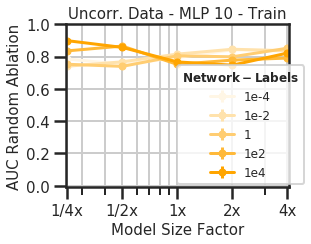

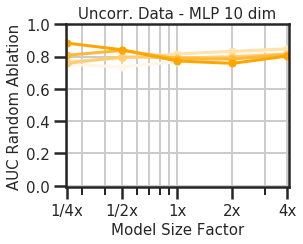

In [141]:
leg_loc = (0.50, 0.02)
  
print_auc(r'Uncorr. Data - MLP 10 - Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, True,
                 "auc_synthetic_initializer2_train")

        
print_auc(r'Uncorr. Data - MLP 10 dim', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network-Labels}$", 0.1,leg_loc, False,
                 "auc_synthetic_initializer2_test")


In [142]:
#Batch - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]

sizes = 5
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

range_len = 7
curves = 4
curve_labels = ['max.',  '4096', '2048', '1024']
curve_colors = ['indianred', 'salmon', 'salmon', 'salmon']
curve_styles = ['-', '-', '--', '--']
marker_styles = ['o', 'v', 's', 'D']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1



ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))


for ID in range(5):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[0, size_idx, 0] = np.mean(rand_ablation_results)
    ablation[0, size_idx, 1] = 0
    targeted_ablation[0, size_idx, 0] = np.mean(targeted_ablation_results)
    targeted_ablation[0, size_idx, 1] = 0
    
    

batch_plot = [4096, 2048, 1024]
for ID in range(13):
    
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    batch_idx = np.where(np.asarray(batch_plot) == opt.hyper.batch_size)[0]
    if len(batch_idx):
        rand_ablation_results = np.zeros((range_len))
        targeted_ablation_results = np.zeros((range_len))
        for amount in range(range_len):
            rand_ablation_results[amount] = \
                np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_type'] == 2] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

            targeted_ablation_results[amount] = \
                np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                    [df['perturbation_type'] == 4] \
                        [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])

        ablation[int(batch_idx)+1, size_idx, 0] = np.mean(rand_ablation_results)
        ablation[int(batch_idx)+1, size_idx, 1] = 0
        targeted_ablation[int(batch_idx)+1, size_idx, 0] = np.mean(targeted_ablation_results)
        targeted_ablation[int(batch_idx)+1, size_idx, 1] = 0



OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

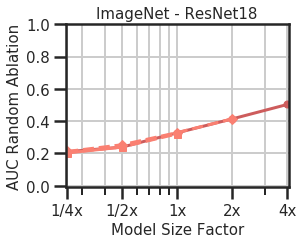

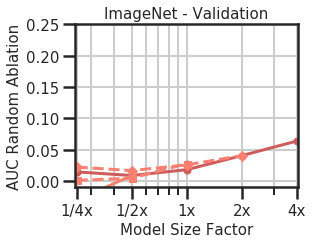

In [143]:
leg_loc = (0.0, 0.42)

print_auc(r'ImageNet - ResNet18', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 0.1,leg_loc, False,
                 "auc_imagenet_batch_test")

yticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
print_auc(r'ImageNet - Validation', ablation-targeted_ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 0.1,leg_loc, False,
                 "target_imagenet_batch_test")




In [144]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
range_len = 7

sizes = 5
levels = np.array(np.linspace(0.0, 1.0, num=range_len))
knockout_range = np.linspace(0.0, 1.0, num=range_len)
level_labels = ["{:.0f}".format(a*100) for a in levels]

range_len = 7
curves = 3
curve_labels = ['ResNet18',  'Inceptionv3', 'Inceptionv3-layer']
curve_colors = ['indianred', 'green', 'lightgreen']
curve_styles = ['-', '-', '--']
marker_styles = ['o', 'v', 's']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1



ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))


for ID in range(5):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[0, size_idx, 0] = np.mean(rand_ablation_results)
    ablation[0, size_idx, 1] = 0
    targeted_ablation[0, size_idx, 0] = np.mean(targeted_ablation_results)
    targeted_ablation[0, size_idx, 1] = 0
    
    

for ID in range(12,15):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '13'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '13'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[1, size_idx, 0] = np.mean(rand_ablation_results)
    ablation[1, size_idx, 1] = 0
    targeted_ablation[1, size_idx, 0] = np.mean(targeted_ablation_results)
    targeted_ablation[1, size_idx, 1] = 0
    
    
for ID in list(range(12,13)) + list(range(15,19)):
    #print('Processing ID:', ID)
    opt = opts[ID]    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    size_idx = size_idx_map[opt.dnn.factor_end]
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '7'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == '7'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[2, size_idx, 0] = np.mean(rand_ablation_results)
    ablation[2, size_idx, 1] = 0
    targeted_ablation[2, size_idx, 0] = np.mean(targeted_ablation_results)
    targeted_ablation[2, size_idx, 1] = 0



OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

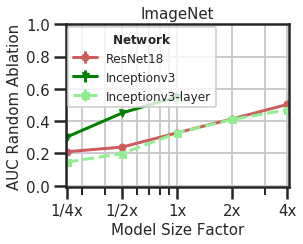

In [145]:
leg_loc = (0.01, 0.49)

print_auc(r'ImageNet', ablation, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Network}$", 0.1,leg_loc, True,
                 "auc_imagenet_test")


In [8]:
ablation

array([[[ 0.21048302,  0.        ],
        [ 0.23911719,  0.        ],
        [ 0.32759064,  0.        ],
        [ 0.41377722,  0.        ],
        [ 0.50314322,  0.        ]],

       [[-0.74795   ,  0.        ],
        [-0.7264758 ,  0.        ],
        [-0.70937614,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.14667633,  0.        ],
        [ 0.19857508,  0.        ],
        [ 0.3275427 ,  0.        ],
        [ 0.41014341,  0.        ],
        [ 0.47046374,  0.        ]]])

OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512
ID: 15, inception, factor: 1, batch_size:512
ID: 16, inception, factor: 1, batch_size:512
ID: 17, inception, factor: 1, batch_size:512
ID: 18, inception, factor: 1, batch_size:512
ID: 19, resnet, factor: 0.25, batch_size:8192
ID: 20, resnet, factor: 0.5, batch_size:4096
ID: 21, resnet, factor: 1, batch_size:3072
ID: 22, re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

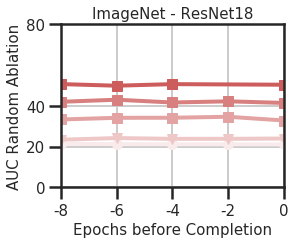

In [147]:
#Time - ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
range_len = 7
curves = 5
curve_labels = ['x1/4',  'x1/2', 'x1', 'x2', 'x4']
cm = seaborn.light_palette("indianred", as_cmap=True)
curve_colors = [cm(i) for i in np.linspace(0.0, 1.0, num=5)]
curve_styles = ['-', '-', '-', '-', '-']
marker_styles = ['o', 'v', 's', 's', 's']
sizes = 5
size_factors = np.array([-4, -3, -2, -1, 0])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['-8', '-6', '-4', '-2', '0']
crosses=3

ablation = np.zeros((curves, sizes, 2))
targeted_ablation = np.zeros((curves, sizes, 2))

# both are indexed [nn_type][size_factor]

for ID in range(19, 38):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]

    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[size_idx][opt.time_step][0] = np.mean(rand_ablation_results)
    ablation[size_idx][opt.time_step][1] = 0
    targeted_ablation[size_idx][opt.time_step][0] = np.mean(targeted_ablation_results)
    targeted_ablation[size_idx][opt.time_step][1] = 0
    
for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_robustness.csv'
    df = pd.read_csv(csv_file)
    rand_ablation_results = np.zeros((range_len))
    targeted_ablation_results = np.zeros((range_len))
    for amount in range(range_len):
        rand_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 2] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
        targeted_ablation_results[amount] = \
            np.array(df[df['evaluation_set'] == 'validation'][df['perturbation_layer'] == 'all'] \
                [df['perturbation_type'] == 4] \
                    [df['perturbation_amount'] == knockout_range[amount]]['unchanged labels'].iloc[0])
        
    ablation[size_idx][-1][0] = np.mean(rand_ablation_results)
    ablation[size_idx][-1][1] = 0
    targeted_ablation[size_idx][-1][0] = np.mean(targeted_ablation_results)
    targeted_ablation[size_idx][-1][1] = 0
    
data = 100*ablation[:, :, 0]
stds = 100*ablation[:, :, 1]
title = r'ImageNet - ResNet18'
leg_title = r"$\bf{Model} \bf{Size}$"
leg_flag = True
rand_base = 0.1

leg_loc = (0.7, 0.040)

fig, ax = plt.subplots(figsize=(4, 3))
plt.title(title , fontsize=25)
plt.xlabel(r'Epochs before Completion', fontsize=25)
plt.ylabel('AUC Random Ablation', fontsize=25)
plt.xlim((-4, 0))
plt.ylim((-0.01, 80))
plt.grid(True, which='both')
plt.xticks(size_factors, size_labels)
plt.yticks([0, 20, 40, 80])

for curve_idx in range(np.shape(data)[0]):
    non_0_idx = (data[curve_idx] != 0)
    plt.errorbar(size_factors[non_0_idx], data[curve_idx][non_0_idx], yerr=stds[curve_idx][non_0_idx], marker=marker_styles[curve_idx], color=curve_colors[curve_idx],
             linestyle=curve_styles[curve_idx], linewidth=4, markersize=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

if False:
    leg = plt.legend(curve_labels, loc=leg_loc, framealpha=0.8, fontsize=12, title=leg_title)
    leg.get_title().set_fontsize('12')
plt.rc('xtick',labelsize=8)

plt.show()
fig.savefig("auc_imagenet_dynamics_test.pdf",format='pdf', bbox_inches='tight',dpi=1000)
    

In [113]:
data

array([[21.04830228, 21.17176769, 21.11542754, 21.06391655,  0.        ],
       [23.91171875, 24.14631696, 23.76021205, 23.77840402,  0.        ],
       [32.75906385, 34.08476506, 34.11328689, 34.5995671 ,  0.        ],
       [41.37772185, 42.95838648, 41.59689322, 42.17354911,  0.        ],
       [50.31432216, 49.83720162, 50.60723397,  0.        ,  0.        ]])